#### Подключение библиотек

In [528]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestRegressor

from matplotlib import pyplot as plt

import seaborn as sns

import catboost as catb

#### Пути к данным

In [529]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SAMPLE_DATASET_PATH = './sample_submission.csv'

#### Функции

In [530]:
# Отчет о классификации
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [531]:
# Классификация и оценка результатов
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

## 1. Базовое решение

### 1.1 Знакомство с данными

In [532]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [533]:
df_train.shape

(7500, 17)

In [534]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [535]:
list(df_train)

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

### 1.2 Простое заполнение пропусков (медианами)

In [536]:
df_train_basic = df_train.fillna(df_train.median)

In [537]:
df_train_basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   object 
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   object 
 9   Bankruptcies                  7500 non-null   object 
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### 1.3 Обучение простой модели (K ближайших соседей)

In [538]:
NUM_FEATURE_NAMES = list(df_train_basic.select_dtypes(include=['float64']))
NUM_FEATURE_NAMES

['Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt']

In [539]:
X = df_train_basic[NUM_FEATURE_NAMES]
y = df_train_basic['Credit Default']

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [541]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [542]:
y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

### 1.4 Подсчет метрики качества

In [543]:
f1_score(y_train, y_train_pred, pos_label=1)

0.49433487201007137

In [544]:
f1_score(y_test, y_test_pred, pos_label=1)

0.23264907135874877

Таким образом, базовая точность на классе 1 - 0,232.

### 2. EDA

### 2.1 Изучение целевой переменной

In [545]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Имеется дисбаланс классов, с которым потом что-то надо будет делать.

### 2.2 Изучение признаков

In [546]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

#### Корреляция между признаками

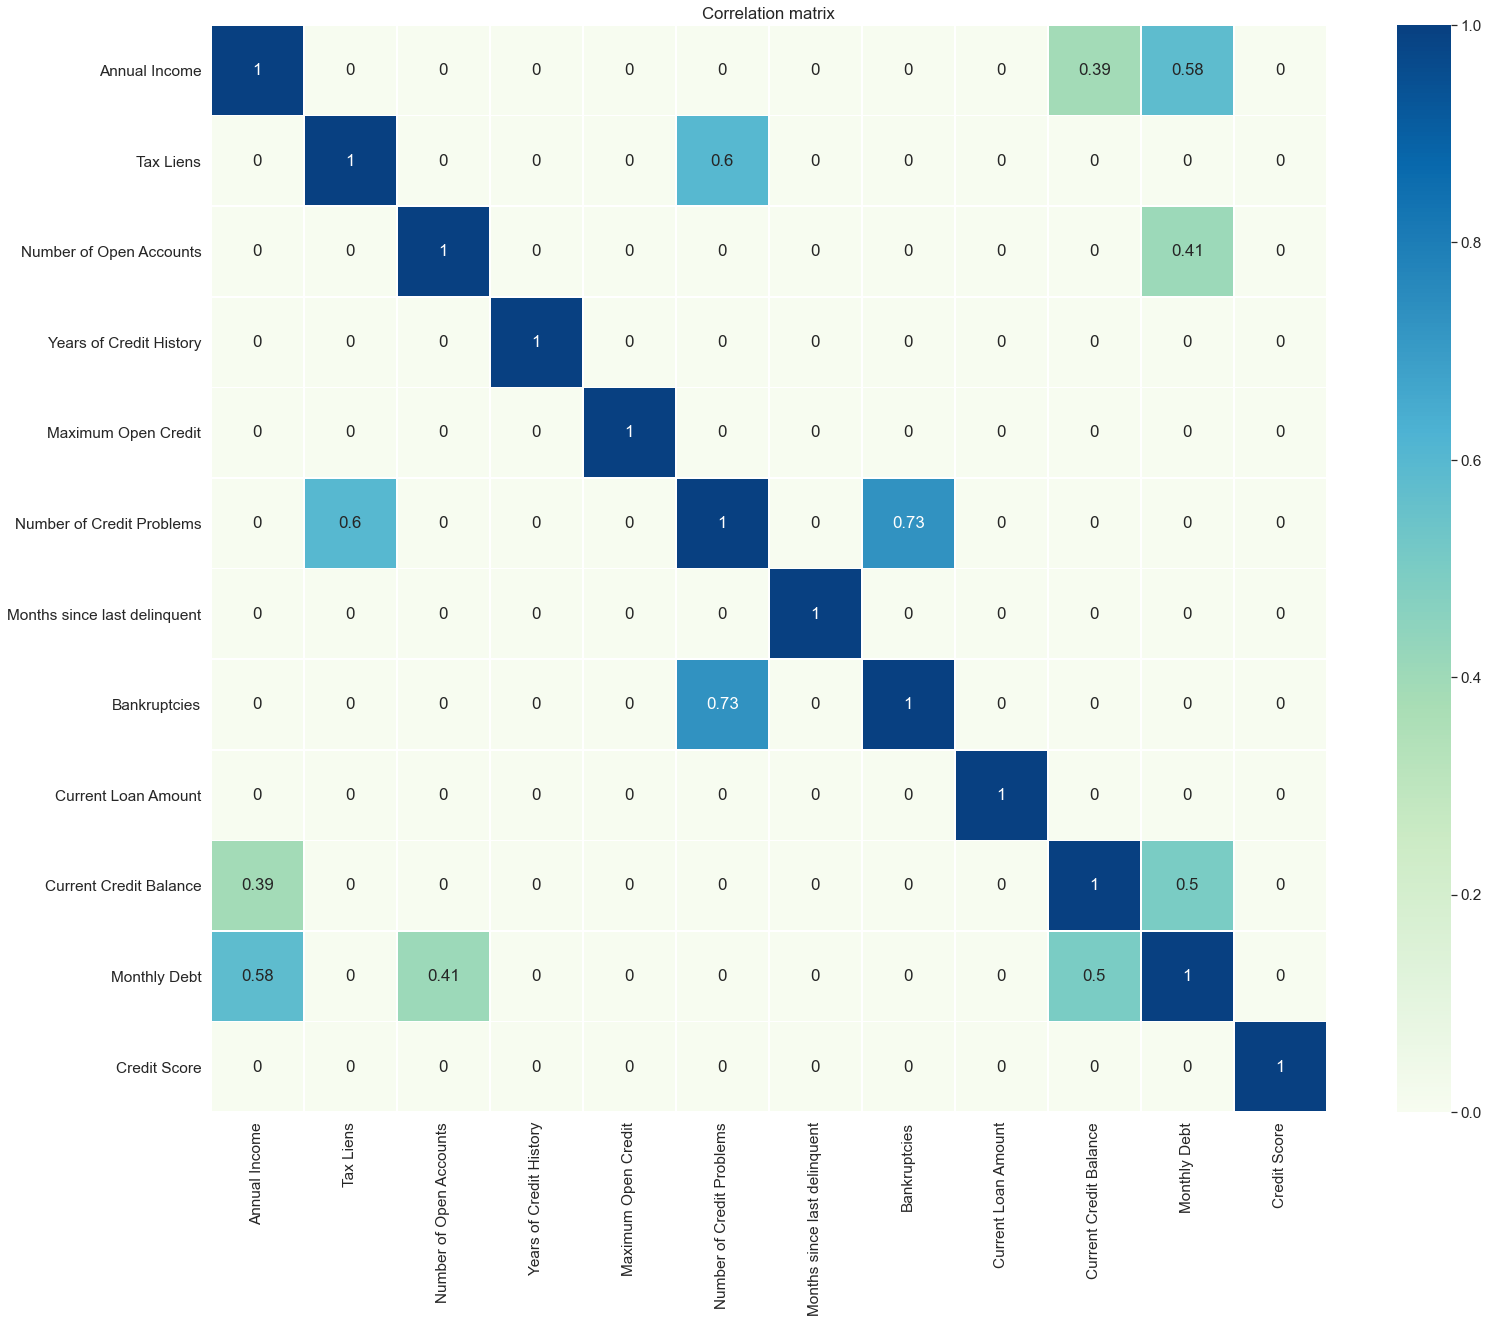

In [547]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df_train[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Наиболее высокие корреляции - у признака Number of Credit Problems с признаками Bankruptcies и Tax Liens, а также у признака Monthly Debt с признаками Annual Income и Current Credit Balance. Надо будет оценить возможность сокращения этих признаков.

#### Проблемные признаки

In [548]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [549]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Есть признаки типа float, которые по своей сути являются int: Number of Open Accounts, Bankruptcies. Их можно преобразовать к int, предварительно проверив, нет ли ошибочных дробных значений.

In [550]:
df_train[df_train['Number of Open Accounts'] % 1 != 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [551]:
df_train[(df_train['Bankruptcies'] % 1 != 0) & (~df_train['Bankruptcies'].isna())]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


Проверим также номинативные признаки, нет ли в них странных и явно ошибочных значений. Судя по картине ниже, все в порядке.

In [552]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

#### Пропуски

In [553]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Есть пропуски в признаках Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score. Нужно будет их заполнить.

#### Выбросы

In [554]:
NUM_FEATURE_NAMES = df_train.select_dtypes(include=['float64'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000004E3ED648B0>,
      dtype=object)

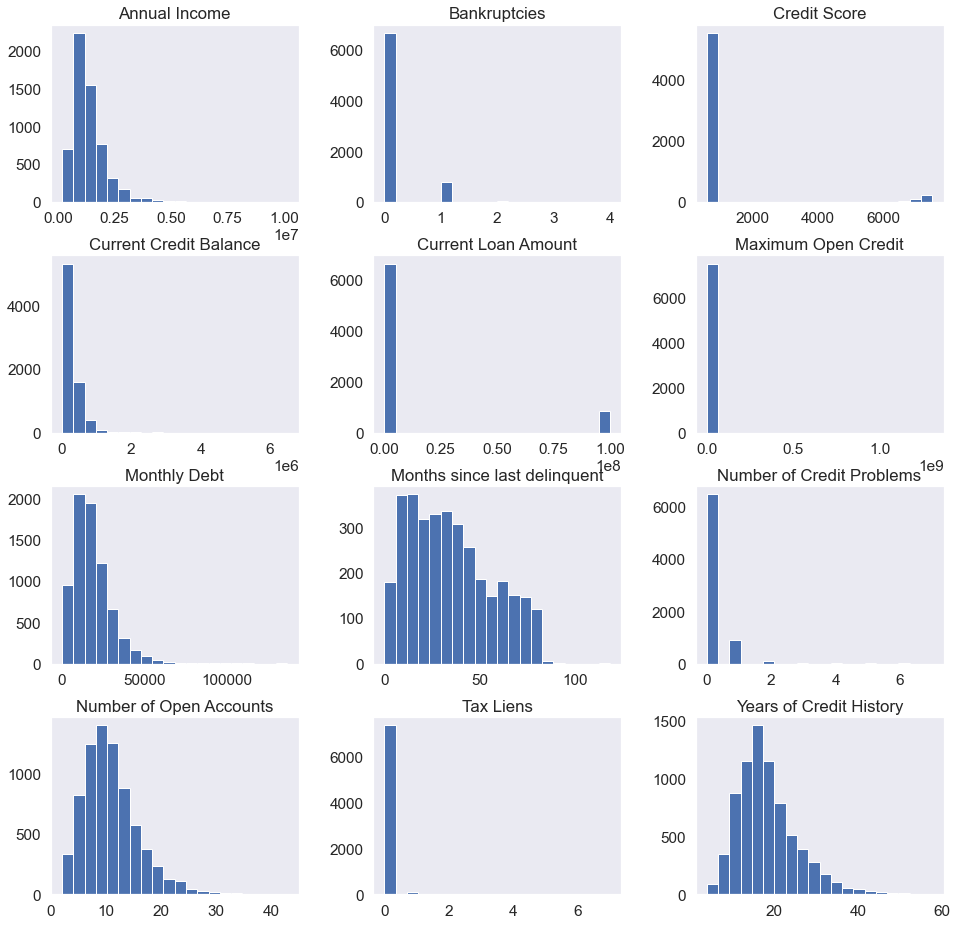

In [555]:
NUM_FEATURE_NAMES.hist(figsize=(16,16), bins=20, grid=False)

Похоже, выбросы есть практически во всех признаках (длинные хвосты справа). Нужно будет их обработать.

### 2.3 Влияние признаков на целевую переменную

#### Корреляция с целевой переменной

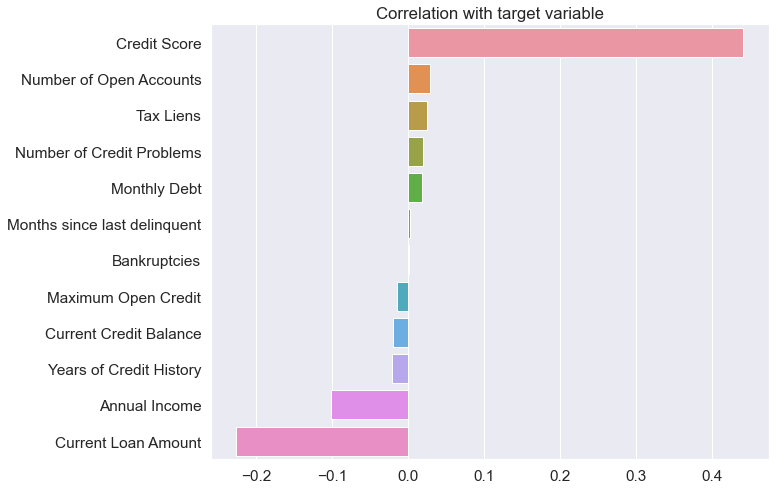

In [556]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Наиболее высокая корреляция имеется у признаков Credit Score, Current Loan Amount и Annual Income. У признаков Credit Score и Annual Income есть пропуски и выбросы, поэтому надо более внимательно отнестись к их заполнению.

## 3. Предобработка данных

### 3.1 Разделение на train и test

In [557]:
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

In [558]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=20,
                                                    stratify=y)

In [559]:
X_train.shape, X_test.shape

((5250, 16), (2250, 16))

### 3.2 Заполнение пропусков

#### Признак Annual Income

In [560]:
df_train['Annual Income'].isna().sum()

1557

Заполним признак медианой. Поскольку нулевых значений много, и признак неплохо коррелирует с целевой переменной, то добавим еще один признак, показывающий, в каких наблюдениях были сгенерированы новые значения.

In [561]:
df_train['Annual_Income_missing'] = 0
df_train.loc[df_train['Annual Income'].isna(), 'Annual_Income_missing'] = 1
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = df_train['Annual Income'].median()

In [562]:
df_train.loc[df_train['Annual_Income_missing'] == 1].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual_Income_missing
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1,1
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1,1
10,Home Mortgage,1168386.0,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0,1
16,Rent,1168386.0,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1,1


#### Признак Months since last delinquent

In [563]:
df_train['Months since last delinquent'].isna().sum()

4081

Признак заполнен менее чем наполовину, поэтому удалим его и не будем использовать.

In [564]:
df_train.drop(columns='Months since last delinquent', inplace=True)

In [565]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default',
       'Annual_Income_missing'],
      dtype='object')

#### Признак Bankruptcies

In [566]:
df_train['Bankruptcies'].isna().sum()

14

Заполним признак медианой.

In [567]:
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = df_train['Bankruptcies'].median()

#### Признак Credit Score

In [568]:
df_train['Credit Score'].isna().sum()

1557

Заполним признак медианой. Поскольку нулевых значений много, и признак сильно коррелирует с целевой переменной, то добавим еще один признак, показывающий, в каких наблюдениях были сгенерированы новые значения.

In [569]:
df_train['Credit_Score_missing'] = 0
df_train.loc[df_train['Credit Score'].isna(), 'Credit_Score_missing'] = 1
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score'] = df_train['Credit Score'].median()

In [570]:
df_train['Credit Score'].isna().sum()

0

#### Признак Years in current job

In [571]:
df_train['Years in current job'].isna().sum()

371

Заменим пропуски на моду.

In [572]:
df_train['Years_in_current_job_outlier'] = 0
df_train.loc[df_train['Years in current job'].isna(), 'Years_in_current_job_outlier'] = 1
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job'] = df_train['Years in current job'].mode(dropna=True).values[0]

In [573]:
df_train['Years in current job'].isna().sum()

0

### 3.3 Приведение типов данных

In [574]:
df_train['Number of Open Accounts'] = df_train['Number of Open Accounts'].astype(np.int64)
df_train['Bankruptcies'] =  df_train['Bankruptcies'].astype(np.int64)

### 3.4 Обработка выбросов

Обработаем выбросы у признаков Credit Score, Current Loan Amount и Annual Income (имеющих наибольшую корреляцию с целевой переменной). Будем считать выбросами значения показателей, большие чем квантиль 97,5% (у всех признаков выбросы справа, а не слева), и заменим их на медиану. 

#### Признак Credit Score

In [575]:
qq = df_train['Credit Score'].quantile(.975)
condition = df_train['Credit Score'] > qq
df_train['Credit_Score_outlier'] = 0
df_train.loc[condition, 'Credit_Score_outlier'] = 1
df_train.loc[condition, 'Credit Score'] = df_train['Credit Score'].median()

#### Признак Current Loan Amount

In [576]:
qq = df_train['Current Loan Amount'].quantile(.975)
condition = df_train['Current Loan Amount'] > qq
df_train['Current_Loan_Amount_outlier'] = 0
df_train.loc[condition, 'Current_Loan_Amount_outlier'] = 1
df_train.loc[condition, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()

#### Признак Annual Income

In [577]:
qq = df_train['Annual Income'].quantile(.975)
condition = df_train['Annual Income'] > qq
df_train['Annual_Income_outlier'] = 0
df_train.loc[condition, 'Annual_Income_outlier'] = 1
df_train.loc[condition, 'Annual Income'] = df_train['Annual Income'].median()

### 3.5 Оформление предобработки в один класс

In [578]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.quantiles = None
        self.years_current_job_mode = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Расчет квантилей
        self.quantiles = X.quantile(.975)
        # Расчет мод
        self.years_current_job_mode = X['Years in current job'].mode()
        print(self.years_current_job_mode)
    
    def transform(self, X):
        """Трансформация данных"""

        # Пропуски в Annual Income
        X['Annual_Income_missing'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual_Income_missing'] = 1
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']      
        
        # Ненужный признак Months since last delinquent
        X.drop(columns='Months since last delinquent', inplace=True)     
        
        # Пропуски в Bankruptcies
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.medians['Bankruptcies']
        
        # Пропуски в Credit Score
        X['Credit_Score_missing'] = 0
        X.loc[X['Credit Score'].isna(), 'Credit_Score_missing'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score'] 
        
        # Пропуски в Years in current job
        X['Years_in_current_job_outlier'] = 0
        X.loc[X['Years in current job'].isna(), 'Years_in_current_job_outlier'] = 1
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = X['Years in current job'].mode(dropna=True).values[0]
                
        # Data type
        X['Number of Open Accounts'] = X['Number of Open Accounts'].astype(np.int64)
        X['Bankruptcies'] =  X['Bankruptcies'].astype(np.int64)
        
        # ВЫбросы в Credit Score
        condition = X['Credit Score'] > self.quantiles['Credit Score']
        X['Credit_Score_outlier'] = 0
        X.loc[condition, 'Credit Score'] = self.medians['Credit Score']
        X.loc[condition, 'Credit_Score_outlier'] = 1

        
        # ВЫбросы в Current Loan Amount
        condition = X['Current Loan Amount'] > self.quantiles['Current Loan Amount']
        X['Current_Loan_Amount_outlier'] = 0
        X.loc[condition, 'Current_Loan_Amount_outlier'] = 1 
        X.loc[condition, 'Credit Score'] = self.medians['Credit Score']
        
        # ВЫбросы в Annual Income
        condition = X['Annual Income'] > self.quantiles['Annual Income']
        X['Annual Income'] = 0
        X.loc[condition, 'Annual Income'] = 1 
        X.loc[condition, 'Annual Income'] = self.medians['Annual Income']
        
        # Заполняем оставшиеся пропуски при необходимости.
        X.fillna(self.medians, inplace=True)
        
        print(X.columns)
        
        return X

### 4. Предобработка данных

#### Создание класса для предобработки

In [579]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_sample = pd.read_csv(SAMPLE_DATASET_PATH, sep=',')

In [580]:
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

In [581]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_train)

df_train = preprocessor.transform(df_train)
df_test = preprocessor.transform(df_test)
df_train.shape, df_test.shape

0    10+ years
dtype: object
Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default',
       'Annual_Income_missing', 'Credit_Score_missing',
       'Years_in_current_job_outlier', 'Credit_Score_outlier',
       'Current_Loan_Amount_outlier'],
      dtype='object')
Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Annual_Income_missing',
       'Credit_Score_missing', 'Years_in_current_job_outlier',
       'Credit_Score_outlie

((7500, 21), (2500, 20))

In [582]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   int64  
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Bankruptcies                  7500 non-null   int64  
 9   Purpose                       7500 non-null   object 
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

#### Отбор признаков

In [583]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
 'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score',
 'Annual_Income_missing', 'Credit_Score_missing', 'Years_in_current_job_outlier', 'Credit_Score_outlier',
 'Current_Loan_Amount_outlier']
CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term', 'Years in current job']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

TARGET_NAME = 'Credit Default'

### 5. Обучение и валидация моделей

#### Разбиение данных на train и test

In [584]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

df_test = df_test[SELECTED_FEATURE_NAMES]

In [585]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

#### Подсчет дисбаланса классов

In [586]:
y_train.value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

In [587]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

#### Классификация с использованием CatBoost

In [588]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

In [589]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3771
           1       0.71      0.83      0.76      1479

    accuracy                           0.86      5250
   macro avg       0.82      0.85      0.83      5250
weighted avg       0.87      0.86      0.86      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1616
           1       0.48      0.55      0.51       634

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.65      2250
weighted avg       0.72      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1244  372
1                286  348


In [590]:
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

In [591]:
f1_score(y_train, y_train_pred, pos_label=1)

0.7625585023400937

In [592]:
f1_score(y_test, y_test_pred, pos_label=1)

0.5140324963072379

Видно, что имеется довольно сильное переобучение.

#### Подбор гиперпараметров

In [593]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20,
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [594]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [595]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [596]:
grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6172381588
bestIteration = 1

0:	loss: 0.6172382	best: 0.6172382 (0)	total: 188ms	remaining: 2.63s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5890131689
bestIteration = 7

1:	loss: 0.5890132	best: 0.6172382 (0)	total: 595ms	remaining: 3.86s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5890131689
bestIteration = 7

2:	loss: 0.5890132	best: 0.6172382 (0)	total: 1.13s	remaining: 4.54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5890131689
bestIteration = 7

3:	loss: 0.5890132	best: 0.6172382 (0)	total: 1.48s	remaining: 4.06s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5890131689
bestIteration = 7

4:	loss: 0.5890132	best: 0.6172382 (0)	total: 1.82s	remaining: 3.65s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6258023575
bestIteration = 5

5:	loss: 0.6258024	best: 0.6258024 (5)	total: 2.09s	remaining: 3.13

In [597]:
grid_search

{'params': {'depth': 7, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

#### Обучение и оценка финальной модели

In [598]:
final_model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=7)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      3771
           1       0.53      0.64      0.58      1479

    accuracy                           0.74      5250
   macro avg       0.69      0.71      0.69      5250
weighted avg       0.76      0.74      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1616
           1       0.47      0.58      0.52       634

    accuracy                           0.70      2250
   macro avg       0.64      0.66      0.65      2250
weighted avg       0.72      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1205  411
1                269  365


Видно, что переобучение снизилось, хотя метрика f1-score особо не возросла.

### 6. Прогнозирование на тестовом датасете

Предобработка тестового датасета уже была выполнена ранее.

In [599]:
predictions = final_model.predict(df_test)
predictions

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [600]:
df_sample['Credit Default'] = predictions
df_sample.head()

,Id,Credit Default
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


In [601]:
df_sample.to_csv('sample_submission.csv', index=False)